#Load the packages

In [1]:
from datasets import load_from_disk
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np

m:\git_projects\LLM\llm-rag-qa-bot\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Loading data from the disk
dataset = load_from_disk(dataset_path='M:\git_projects\LLM\llm-rag-qa-bot\data\cnn_dailymail')
print(dataset)
print(dataset['train']['article'][0])
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap=50,
)
texts = text_splitter.split_text(dataset["train"][0]["article"])
print(texts)

<>:2: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\g'
C:\Users\aksha\AppData\Local\Temp\ipykernel_8852\2160500677.py:2: SyntaxWarning: invalid escape sequence '\g'
  dataset = load_from_disk(dataset_path='M:\git_projects\LLM\llm-rag-qa-bot\data\cnn_dailymail')


DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})
LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think 

In [2]:
embedder = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2",  # 384-dim, free
    model_kwargs={"device": "cpu"}  # No GPU needed
)
print(embedder)

# visualize embeddings
# Sample sentences
sentences = [
    "The capital of France is Paris.",
    "Paris is known for the Eiffel Tower.",
    "Cats are popular pets.",
    "Dogs are loyal animals.",
    "Machine learning is a subset of AI."
]

# Generate embeddings (384-dimensional vectors)
embeddings = embedder.embed_documents(sentences)  # Returns a list of numpy arrays
embeddings = np.array(embeddings)  # Convert to numpy matrix (5x384)
print(embeddings.shape)

C:\Users\aksha\AppData\Local\Temp\ipykernel_8852\300740794.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedder = HuggingFaceEmbeddings(


client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
) model_name='sentence-transformers/all-MiniLM-L6-v2' cache_folder=None model_kwargs={'device': 'cpu'} encode_kwargs={} multi_process=False show_progress=False
(5, 384)


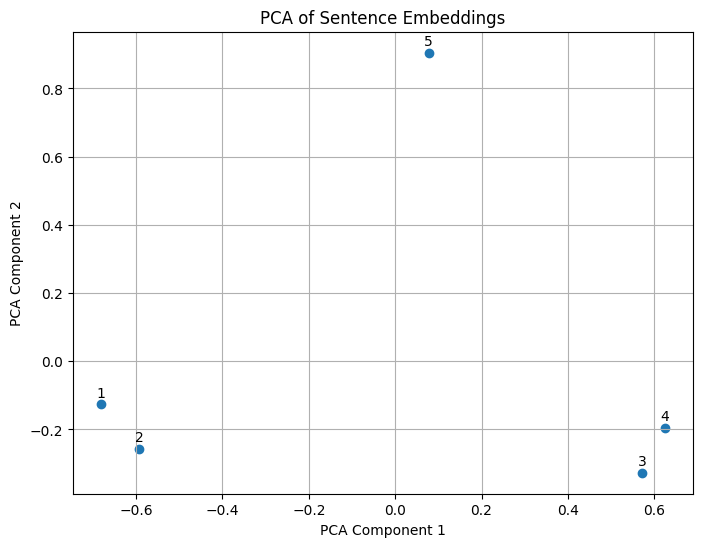

In [ ]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

# Annotate points
for i, sentence in enumerate(sentences):
    plt.annotate(
        f"{i+1}",  # Label with sentence number
        (embeddings_2d[i, 0], embeddings_2d[i, 1]),
        textcoords="offset points",
        xytext=(0, 5),
        ha='center'
    )

plt.title("PCA of Sentence Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid()
plt.show()

# Checking if the embeddings are interpretable using PCA

In [ ]:
vector_db = FAISS.from_texts(texts, embedder)
vector_db.save_local("models/cnn_faiss_index")  # Reusable index
# Get embeddings from FAISS
embeddings = vector_db.index.reconstruct_n(0, vector_db.index.ntotal)

# to confirm on the closeness of the document if FAISS is doing good job in finding the similarity
sim_matrix = cosine_similarity(embeddings)  # Original embeddings (not PCA-reduced)

# Compare Doc 1 and Doc 2
print(f"Similarity (Doc 1 vs Doc 2): {sim_matrix[0, 1]:.2f}")
# Compare Doc 1 and Doc 3
print(f"Similarity (Doc 1 vs Doc 3): {sim_matrix[0, 2]:.2f}")
# Compare Doc1 and Doc6
print(f"Similarity (Doc 1 vs Doc 6): {sim_matrix[0, 5]:.2f}")


Similarity (Doc 1 vs Doc 2): 0.64
Similarity (Doc 1 vs Doc 3): 0.79
Similarity (Doc 1 vs Doc 6): 0.31


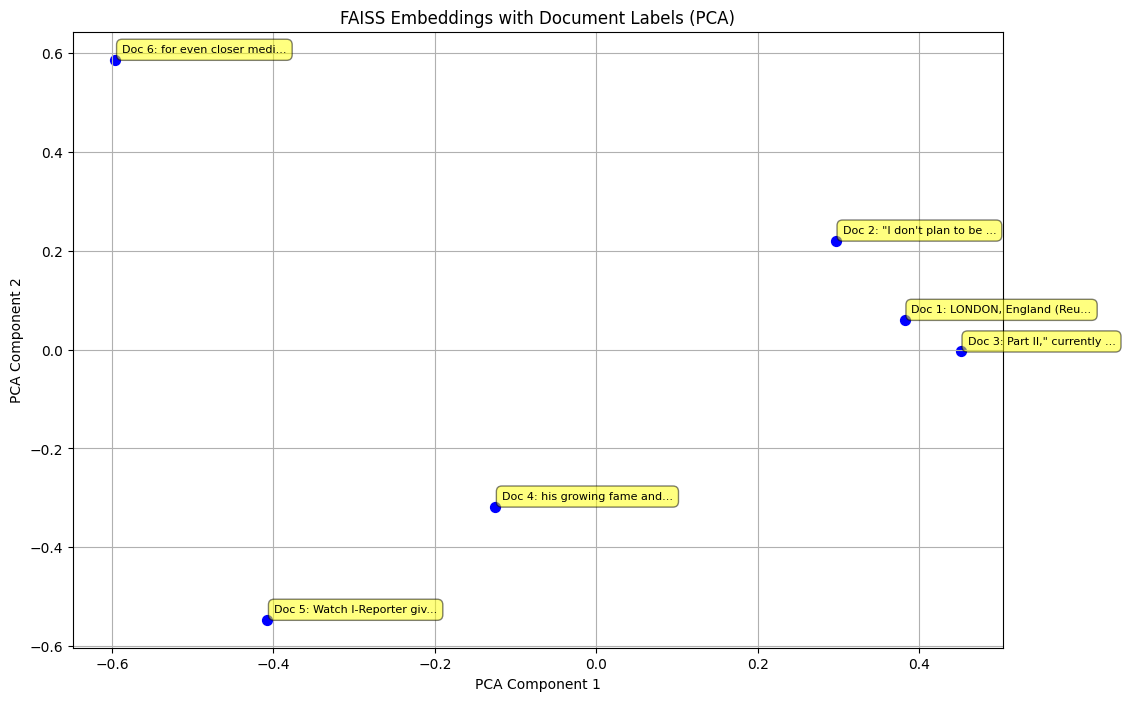

In [ ]:
# Reduce to 2D with PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', s=50)

# Annotate each point with its text snippet
for i, (x, y) in enumerate(embeddings_2d):
    plt.annotate(
        f"Doc {i+1}: {texts[i][:20]}...",  # Show first 20 chars
        (x, y),
        fontsize=8,
        xytext=(5, 5),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5)
    )

plt.title("FAISS Embeddings with Document Labels (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid()
plt.show()

# Document 1 is closer t Document 3 rather than the document 6
